<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Ressentis_distilBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification de ressentis avec distilBERT**

L'objectif est de créer un modèle qui prend en entrée des commentaires (en Anglais) et attribue à chacun un ressenti positif ou négatif.  
Le modèle est composé de deux parties :  
* [DistilBERT](https://huggingface.co/transformers/model_doc/distilbert.html) (une version allégée de BERT) va encoder le commentaire et en extraire des informations qui seront passées ensuite au réseau de neurones.  
* Le modèle suivant est un réseau de neurones qui sera créé avec l'API [Keras](https://www.tensorflow.org/guide/keras?hl=fr) de [Tensorflow](https://www.tensorflow.org/?hl=fr).  

<img src="https://raw.githubusercontent.com/AlexandreBourrieau/ML-F1/master/Carnets%20Jupyter/Images/StructureBERT.png" />  
  
  Les données qui s'échangent entre les deux modèles sont des vecteurs de dimension 768. On peut voir ces vecteurs comme l'équivalent de l'application d'un algorithme de prolongation lexicale sur les mots qui composent le commentaire.

# **Installation et importation des librairies**


In [1]:
!pip install transformers --quiet

     |████████████████████████████████| 1.1MB 8.1MB/s 
     |████████████████████████████████| 1.1MB 7.3MB/s 
     |████████████████████████████████| 890kB 59.0MB/s 
     |████████████████████████████████| 3.0MB 55.7MB/s 


In [54]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout, Input, Dropout, Lambda, Conv1D, GlobalMaxPooling1D
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

from transformers import DistilBertConfig
from transformers import TFDistilBertModel
from transformers import AutoTokenizer

import matplotlib.pyplot as plt

import random

# **Importation des données**

On utilise la librairie pandas pour lire les données depuis le fichier csv disponible sur le site de [standford](https://nlp.stanford.edu/sentiment/index.html) qui contient des commentaires sur des films, chacun d'eux avec une note positive (1) ou négative (0).

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/AlexandreBourrieau/ML-F1/master/Carnets%20Jupyter/Donn%C3%A9es/train.csv', delimiter='\t', header=None)

Affiche quelques informations :

In [36]:
def LongueurMax(df):
  Lmax = 0
  for com in df[0]:
    Longueur = len(com)
    if Lmax < Longueur:
      Lmax = Longueur
  return Lmax


In [37]:
print(df[0:10])
print("Total des données : ", str(len(df)))
print("Nombre d'avis positifs et négatifs : ",df[1].value_counts())
print("Longueur maximale d'un commentaire : ",LongueurMax(df))

                                                   0  1
0  a stirring , funny and finally transporting re...  1
1  apparently reassembled from the cutting room f...  0
2  they presume their audience wo n't sit still f...  0
3  this is a visually stunning rumination on love...  1
4  jonathan parker 's bartleby should have been t...  1
5  campanella gets the tone just right funny in t...  1
6  a fan film that for the uninitiated plays bett...  0
7  b art and berling are both superb , while hupp...  1
8  a little less extreme than in the past , with ...  0
9                       the film is strictly routine  0
Total des données :  6920
Nombre d'avis positifs et négatifs :  1    3610
0    3310
Name: 1, dtype: int64
Longueur maximale d'un commentaire :  271


# **Préparation des données**

# Séparation des données d'entrainement et de test 
On commence par récupérer 75% des données pour l'entrainement, et le reste pour les tests :

<img src="https://github.com/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Images/SeparationData.png?raw=true"/>

In [38]:
# Chargement des commentaires et des ressentis
commentaires = df[0].astype(str).tolist()    # Récupère tous les commentaires dans une liste python
ressentis = df[1].tolist()                   # Récupère tous les ressentis dans une liste python
labels = np.asarray(ressentis)               # Créé un tableau de type numpy avec les ressentis

x_entrainement, x_test, y_entrainement, y_test = train_test_split(commentaires, labels, test_size=0.25)

# Tokénisation  
La première étape est de tokéniser les commentaires : les mots sont décomposés en index numériques au format BERT.  

<img src="https://github.com/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Images/TokenizeBERT.png?raw=true"/>

Après tokénisation, on obtient une liste de séquences et chaque séquence représente une liste d'index. On souhaite que BERT analyse toutes les séquences en une seule fois (ce qui est plus rapide). Il faut donc que toutes les séquences aient la même taille. On va donc ajouter du bourrage pour égaliser la longueur des séquences. Cela est indiqué avec le paramètre `padding='True'`.  
Lorsque un bourrage est ajouté, il faut que BERT ne prenne pas en compte les mots à cette position (car il n'y en a pas !). Cette restriction est réalisé grace à l'`attention_mask`

In [39]:
LONGUEUR_MAX_COMMENTAIRE = LongueurMax(df) + 2

# Instanciation du tokeniseur
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Préparation des données d'entrainement
output_tokenizer_entrainement = tokenizer(x_entrainement,max_length=LONGUEUR_MAX_COMMENTAIRE, padding='max_length', truncation=False, return_tensors='tf',add_special_tokens=True)

# Préparation des données de tests
output_tokenizer_tests = tokenizer(x_test,max_length=LONGUEUR_MAX_COMMENTAIRE, padding='max_length', truncation=False, return_tensors='tf',add_special_tokens=True)

Regardons un peu comment sont formatées les données en sortie du tokéniseur :

In [40]:
output_tokenizer_entrainement

{'input_ids': <tf.Tensor: shape=(5190, 273), dtype=int32, numpy=
array([[  101,  4632, 12186, ...,     0,     0,     0],
       [  101,  2004,  1996, ...,     0,     0,     0],
       [  101,  2065,  2940, ...,     0,     0,     0],
       ...,
       [  101,  2009,  1005, ...,     0,     0,     0],
       [  101,  2672,  2025, ...,     0,     0,     0],
       [  101,  2054,  3084, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(5190, 273), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

Regardons comment le premier commentaire a été encodé :

In [41]:
print("Commentaire original :", x_entrainement[0])
print("input_ids: ", output_tokenizer_entrainement['input_ids'][0])
print("attention_mask: ", output_tokenizer_entrainement['attention_mask'][0])

Commentaire original : assayas ' ambitious , sometimes beautiful adaptation of jacques chardonne 's novel
input_ids:  tf.Tensor(
[  101  4632 12186  2015  1005 12479  1010  2823  3376  6789  1997  7445
 25869  5280  2638  1005  1055  3117   102     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0  

Regardons les 5 premiers résultats de la tokénisation : On peut identifier les mot-clés **[CLS]** (valeur : 101) et **[SEP]** (valeur : 102)

In [ ]:
for i in range (0,5):
  print(output_tokenizer_entrainement['input_ids'][i])

tf.Tensor(
[  101  1037 18385  1010  6057  1998  2633 18276  2128 16603  1997  5053
  1998  1996  6841  1998  5687  5469  3152   102     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0    

# **Définition et utilisation du modèle distilBERT avec Keras**

Les données d'entrées étant maintenant correctement préparées, commençons par définir le modèle distilBERT pour ensuite l'appliquer aux données afin de réaliser l'opération de prolongation lexicale.  

<img src="https://github.com/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Images/DistilBERT_process.png?raw=true"/>  
La fonction `model()` permet d'exécuter le modèle sur les séquences d'entrées.

In [20]:
# Configuration du modèle distilBERT
config = DistilBertConfig(num_labels=2)           # 2 label
config.output_hidden_states = True               # Ne récupère pas la totalité des couches mais uniquement la dernière
config.output_attentions = False

# Instanciation du modèle distilBERT
transformer_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config = config)

# Défintion du format des entrées du modèle
entrees_ids = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='input_token', dtype='int32')
entrees_masks = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='masked_token', dtype='int32') 

# Création de la sortie du modèle
sortie_distilBERT = transformer_model([entrees_ids,entrees_masks])

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Pour chaque commentaire en entrée, la sortie du modèle distilBERT est un vecteur de dimension MAX_SEQUENCE_LENGTH :
* Il y a au maximum MAX_SEQUENCE_LENGTH mots dans chaque commentaire
* Il y a un vecteur en sortie du modèle par mot dans chaque commentaire
* Le vecteur qui code chaque mot est de dimension 768

Vérifions cela en regardant le format de la sortie du modèle :

In [ ]:
sortie_distilBERT

(<tf.Tensor 'tf_distil_bert_model_2/distilbert/transformer/layer_._5/output_layer_norm/batchnorm/add_1:0' shape=(None, 100, 768) dtype=float32>,)

Définissons maintenant le modèle distilBERT :

In [21]:
model_distilBERT = tf.keras.Model(inputs=[entrees_ids, entrees_masks], outputs = sortie_distilBERT,trainable=False)
model_distilBERT.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 500)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 500)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_3 (TFDisti ((None, 500, 768), ( 66362880    input_token[0][0]                
                                                                 masked_token[0][0]               
Total params: 66,362,880
Trainable params: 0
Non-trainable params: 66,362,880
__________________________________________________________________________________________________


In [ ]:
sortie_vecteurs_distilBERT = model_distilBERT.predict(
    [output_tokenizer_entrainement['input_ids'][0:2],
     output_tokenizer_entrainement['attention_mask'][0:2]]
     ,verbose=1)

1/1 [==============================] - 0s 5ms/step


In [ ]:
sortie_vecteurs_distilBERT

(array([[[-0.00069188,  0.01487034, -0.00226291, ..., -0.0357077 ,
          -0.00973538,  0.10901202],
         [-0.00069189,  0.01487034, -0.0022629 , ..., -0.0357077 ,
          -0.0097354 ,  0.10901202],
         [-0.00069188,  0.01487033, -0.0022629 , ..., -0.0357077 ,
          -0.00973539,  0.10901203],
         ...,
         [-0.00069189,  0.01487035, -0.00226292, ..., -0.03570769,
          -0.00973541,  0.10901202],
         [-0.00069188,  0.01487035, -0.0022629 , ..., -0.03570771,
          -0.0097354 ,  0.10901202],
         [-0.00069188,  0.01487034, -0.0022629 , ..., -0.0357077 ,
          -0.0097354 ,  0.109012  ]],
 
        [[-0.00069192,  0.01487029, -0.00226293, ..., -0.03570767,
          -0.00973539,  0.10901193],
         [-0.00069193,  0.01487028, -0.00226291, ..., -0.03570767,
          -0.00973539,  0.10901191],
         [-0.00069192,  0.01487029, -0.00226291, ..., -0.03570767,
          -0.00973539,  0.10901193],
         ...,
         [-0.00069193,  0.0148702

In [ ]:
sortie_vecteurs_distilBERT[0][0][0]

Exécutons maintenant distilBERT sur les 10 premiers commentaires afin de regarder le format des sorties obtenues :

In [ ]:
sortie_vecteurs_distilBERT = model_distilBERT.predict(
    [output_tokenizer_entrainement['input_ids'][0:10],
     output_tokenizer_entrainement['attention_mask'][0:10]]
     ,verbose=1)
print("Commentaire :", commentaires[1])
print("input_ids", output_tokenizer_entrainement['input_ids'][1])
print("Sortie BERT", sortie_vecteurs_distilBERT[0][:,0,:])

1/1 [==============================] - 0s 12ms/step
Commentaire : apparently reassembled from the cutting room floor of any given daytime soap
input_ids tf.Tensor(
[  101  1996  2143 16142  2046  1037  6907  2008  2038  2042  2058 10288
 19155  1010  2417  9890  3372  1997  1037  4595 18856 17322  2015  1010
  1998  2664  3464 20640  2993  1010 17026  2007  2434  3012   102     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0   

Parmi les MAX_SEQUENCE_LENGTH vecteurs en sortie, il ne nous faut que le premier (celui qui correspond au mot clé [CLS]). On doit donc récupérer, pour chaque commentaire, le premier vecteur de dimension 768 parmi les MAX_SEQUENCE_LENGTH en sortie :  
  
  
<img src="https://github.com/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Images/Slice_SortieBERT.png?raw=true"/>  

# **Ajout du réseau de neurones simple en sortie du modèle distilBERT**

In [22]:
sortie_distilBERT[0]

<tf.Tensor 'tf_distil_bert_model_3/distilbert/transformer/layer_._5/output_layer_norm/batchnorm/add_1:0' shape=(None, 500, 768) dtype=float32>

In [61]:
# Configuration du modèle distilBERT
config = DistilBertConfig(num_labels=2)           # 1 label
config.output_hidden_states = True               # Ne récupère pas la totalité des couches mais uniquement la dernière
config.output_attentions = False

# Instanciation du modèle distilBERT
transformer_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config = config)

# Défintion du format des entrées du modèle
entrees_ids = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='input_token', dtype='int32')
entrees_masks = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='masked_token', dtype='int32') 

# Création de la sortie du modèle
sortie_distilBERT = transformer_model([entrees_ids,entrees_masks])[0]


l1 = Lambda(lambda seq: seq[:, 0, :])(sortie_distilBERT)
output = Dense(2, activation='softmax')(l1)

model = tf.keras.Model(inputs=[entrees_ids, entrees_masks], outputs = output)
model.layers[2].trainable = False
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_projector', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 273)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 273)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_15 (TFDist ((None, 273, 768), ( 66362880    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
lambda_13 (Lambda)              (None, 768)          0           tf_distil_bert_model_

In [ ]:
output_tokenizer_entrainement['input_ids'][0:MAX_SIZE]

<tf.Tensor: shape=(500, 300), dtype=int32, numpy=
array([[  101,  3010, 12127, ...,     0,     0,     0],
       [  101,  2049, 17839, ...,     0,     0,     0],
       [  101,  2777,  2594, ...,     0,     0,     0],
       ...,
       [  101,  2009,  1005, ...,     0,     0,     0],
       [  101,  1047,  2539, ...,     0,     0,     0],
       [  101,  2044,  1037, ...,     0,     0,     0]], dtype=int32)>

In [ ]:
tf.reshape(y_test[0:MAX_SIZE],[MAX_SIZE,1])

In [ ]:
output_tokenizer_entrainement['input_ids'][0:MAX_SIZE]

<tf.Tensor: shape=(500, 300), dtype=int32, numpy=
array([[  101,  1037, 18385, ...,     0,     0,     0],
       [  101,  4593,  2128, ...,     0,     0,     0],
       [  101,  2027,  3653, ...,     0,     0,     0],
       ...,
       [  101,  4983,  2017, ...,     0,     0,     0],
       [  101,  2019, 18114, ...,     0,     0,     0],
       [  101,  1037, 17075, ...,     0,     0,     0]], dtype=int32)>

In [52]:
history = model.fit([output_tokenizer_entrainement['input_ids'],output_tokenizer_entrainement['attention_mask']],y_entrainement,
                    epochs=5, verbose=1, batch_size = 3,
                    validation_data=([output_tokenizer_tests['input_ids'],output_tokenizer_tests['attention_mask']],y_test))


Epoch 1/5
1730/1730 [==============================] - 54s 31ms/step - loss: 0.4687 - accuracy: 0.7707 - val_loss: 0.3815 - val_accuracy: 0.8341
Epoch 2/5
1730/1730 [==============================] - 53s 31ms/step - loss: 0.4120 - accuracy: 0.8123 - val_loss: 0.3776 - val_accuracy: 0.8312
Epoch 3/5
 697/1730 [===========>..................] - ETA: 22s - loss: 0.4015 - accuracy: 0.8154

KeyboardInterrupt: ignored

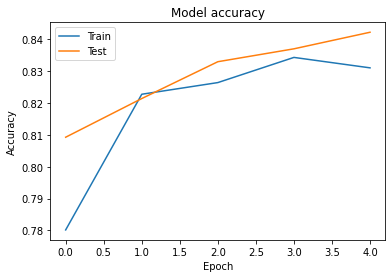

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# **Fine Tuning**

In [62]:
model.layers[2].trainable = True
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(1e-5), metrics=['accuracy'])
model.summary()

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 273)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 273)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_15 (TFDist ((None, 273, 768), ( 66362880    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
lambda_13 (Lambda)              (None, 768)          0           tf_distil_bert_model_

In [63]:
history = model.fit([output_tokenizer_entrainement['input_ids'],output_tokenizer_entrainement['attention_mask']],y_entrainement,
                    epochs=5, verbose=1, batch_size = 3,
                    validation_data=([output_tokenizer_tests['input_ids'],output_tokenizer_tests['attention_mask']],y_test))

Epoch 1/5
1730/1730 [==============================] - 132s 76ms/step - loss: 0.3690 - accuracy: 0.8351 - val_loss: 0.2778 - val_accuracy: 0.8913
Epoch 2/5
1730/1730 [==============================] - 131s 76ms/step - loss: 0.1494 - accuracy: 0.9464 - val_loss: 0.2769 - val_accuracy: 0.8988
Epoch 3/5
1730/1730 [==============================] - 131s 76ms/step - loss: 0.0646 - accuracy: 0.9769 - val_loss: 0.3761 - val_accuracy: 0.8861
Epoch 4/5
1730/1730 [==============================] - 131s 76ms/step - loss: 0.0308 - accuracy: 0.9886 - val_loss: 0.4540 - val_accuracy: 0.8844
Epoch 5/5
1730/1730 [==============================] - 131s 76ms/step - loss: 0.0228 - accuracy: 0.9931 - val_loss: 0.5731 - val_accuracy: 0.8971


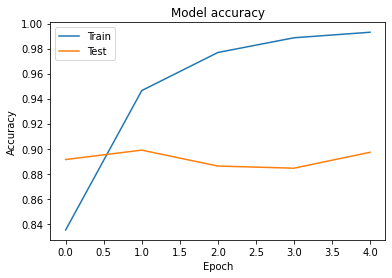

In [65]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# **Un modèle plus complexe**